# Assignment-13

Design of ResNet-18 Architecture and Training the model with CIFAR-10 to target a 90% accuracy.

In [115]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

## Loading and Normalization

Image was loaded into NumPy Arrays and normalized better regularization. Other regularization techniques like ZCA whitening was used and the accuracy was found to be 87.79% over 87.01% with simple image normalization. 

In [5]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(trainx, trainy), (testx, testy) = cifar10.load_data()
ntrain, rows, cols, ch =  trainx.shape
ntest, _, _, _         =  testx.shape
ncls = len(np.unique(trainy))
print(ncls)

trainx = trainx.astype('float32') / 255
testx = testx.astype('float32') / 255

trainx_mean = trainx.mean(axis=0)
trainx_std  = trainx.std(axis=0)

#print(trainx_mean, trainx_std)

datagen = ImageDataGenerator(zca_whitening=True)

datagen.fit(trainx)

iterate = datagen.flow(trainx, trainy, batch_size=len(trainx), shuffle=False)

trainx, trainy = iterate.next()

iterate = datagen.flow(testx, testy, batch_size=len(testx), shuffle=False)

testx, testy = iterate.next()

# trainx -= trainx_mean
# trainx /= trainx_std

# testx -= trainx_mean
# testx /= trainx_std

def smooth_categorical(y, ls=0.8):
    ncls = np.max(y) + 1
    shp  = np.shape(y)[0], ncls
    yy = np.random.uniform(1e-6, 2*(1-ls)/(ncls-1), shp)
    for i in range(len(y)):
        yy[i, y[i]] = ls
        yy[i]/=np.sum(yy[i])
    return yy
    

10
-28.404232 35.503895
-38.652294 33.47046
(50000, 32, 32, 3) (50000, 10)


In [129]:
trainX, trainY = trainx, smooth_categorical(trainy, ls=0.8) # utils.to_categorical(trainy)
testX,  testY  = testx,  smooth_categorical(testy, ls=0.8)  # utils.to_categorical(testy)

min_pix, max_pix = trainX.min(), trainX.max()

print(min_pix, max_pix)
print(testX.min(), testX.max())

print(trainX.shape, trainY.shape)


print(trainY[0:4,:])

-28.404232 35.503895
-38.652294 33.47046
(50000, 32, 32, 3) (50000, 10)
[[2.13694756e-02 2.68736788e-02 9.25350084e-03 1.17794634e-02
  3.70322165e-02 3.42298665e-02 7.82116188e-01 2.96490599e-02
  3.98399447e-02 7.85660565e-03]
 [8.64358892e-05 1.21771838e-02 3.99508669e-02 2.57422089e-02
  9.12550765e-03 3.54486573e-02 4.39153237e-02 4.06854228e-03
  1.39626597e-02 8.15522614e-01]
 [3.23001870e-03 6.07716396e-03 1.59292499e-02 5.28521676e-03
  3.69674685e-02 1.59289332e-02 2.33739912e-02 3.83077602e-02
  2.91463933e-02 8.25753804e-01]
 [1.39439223e-02 1.27803400e-02 3.94465107e-02 4.06337334e-02
  7.77223416e-01 2.60151644e-02 2.26207310e-02 2.98326575e-02
  2.88534790e-02 8.65004526e-03]]


## Hyperparameters 

In [130]:
BATCH_SIZE = 512
WT_DECAY   = 5e-5
LRFNEPOCH  = 4
MOMENTUM   = 0.9
EPOCHS     = 300
LEARNING_RATE = 0.01

## ResNet Model Design

ResNet Architecture is composed of the following:

1. Conv2D(7x7)
2. Followed by MaxPooling
3. Followed by Deep ResNet Blocks
4. Each ResNetBlock has ResNet Units
5. Each ResNet Units contains convolution blocks
6. Each Convolution block is a mix of BatchNormalization, Activation, MaxPooling and Convolution without strides
7. The width of the layers increases exponentially at a ratio of 2 (64, 128, 256, 512)
8. Fully pre-activated ResNet blocks are used for convolution
9. The order of BatchNormalization, Activation, Followed by Convolution is carried out based on the efficiency recommendations from the DavidNet 8 papers.
10. The strides were modified with MaxPooling but the same did not lead to additional benefits as such. 

The Blocks were such designed such that ResNet-9 as well as ResNet-18 can be configured using the same building blocks and are presented below. 


In [131]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D
from tensorflow.keras.initializers import zeros


def ResConv(x, kernel=(3, 3), depth=32, maxpool=False):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if maxpool :
        x = MaxPool2D()(x)
    x = Conv2D(depth, kernel, padding='same', use_bias=False)(x)
    return x

def ResUnit(x, depth=32, maxpool=False):
    x = ResConv(x, depth=depth, maxpool=maxpool)
    x = ResConv(x, depth=depth)
    return x
    
def ResNetBlock(x, nunit, depth=32, maxpool=False, name="Block-1"):
    assert nunit > 0, "Ensure there are at least 1 unit in the ResNet Block"
    nunit -= 1
    if maxpool:
        xskip = Conv2D(depth, (1, 1), strides=2, use_bias=False)(x)
    else: 
        xskip = x
    x = add([ResUnit(x, depth=depth, maxpool=maxpool), xskip])
    if nunit >= 1:
        nunit -= 1
        for i in range(nunit):
            x = add([ResUnit(x, depth=depth), x])
        x = add([ResUnit(x, depth=depth), x], name=name)
    return x
        
def ResNet18(x):
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = MaxPool2D((3, 3),  strides=2, padding='same')(x)
    
    nunits   = (2, 2, 2, 2)
    maxpools = (False, True, True, True)
    depths   = (64, 128, 256, 512)
    
    for i in range(4):
        x = ResNetBlock(x, nunits[i], depth=depths[i], maxpool=maxpools[i], name="Block-"+str(i))
    x = GlobalAvgPool2D()(x)
    return x

def ResNet9(x):
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(x)
    x = MaxPool2D((3, 3),  strides=2, padding='same')(x)
    
    nunits   = (2, 3, 2)
    maxpools = (False, True, True)
    depths   = (64, 128, 256)
    
    for i in range(3):
        x = ResNetBlock(x, nunits[i], depth=depths[i], maxpool=maxpools[i], name="Block-"+str(i))
    x = GlobalAvgPool2D()(x)
    return x


## Optimizers and Training

1. SGD with momentum was used for used for training. 
2. Custom L2 regularizer was designed rather than using the standard Keras layers based model to ensure the L2 regularizer can be controlled dynamically. The experiments there were not very successful in improving model accuracy significantly. 

In [132]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

def l2_weights(model):
    l2 = 0
    for layer in model.layers: 
        wt = layer.weights
        if len(wt) > 0:
            l2 += K.sum(K.pow(wt, 2))
    return l2

def reg_loss(model):
    def rloss(y_true, y_pred):
        return model.l2_reg*l2_weights(model)
    return rloss

def loss_with_regularization(model):
    def loss(y_true, y_pred):
        print(y_true.shape)
        
        tv = K.greater_equal(y_pred, 0.25)
        tv = K.cast(tv, K.floatx())
        ypd = tv + ((1-tv)*y_pred)
        yp = (1.0 - K.pow(ypd, 0.8))/0.8
        tloss = K.mean(K.sum(y_true*yp, axis=1), axis=0)
        return tloss + reg_loss(model)(y_true, y_pred)
    return loss

def model_init(optimizer=None):
    xin = Input(shape=(32, 32, 3), name="Input")
    x = ResNet18(xin)
    x = Dense(ncls, use_bias=False)(x)
    y = Activation('softmax')(x)
    model = Model(xin, y)
    model.l2_reg = K.variable(value=WT_DECAY, dtype='float32', name='reg_loss')
    if optimizer is None:
        optimizer = SGD(lr=1e-3, momentum=MOMENTUM, nesterov=True)
    model.compile(optimizer=optimizer, loss=loss_with_regularization(model), metrics=['acc', reg_loss(model)])
    return model

model = model_init()
model.summary()

(?, ?)
Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1000 (Conv2D)            (None, 16, 16, 64)   9408        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_200 (MaxPooling2D (None, 8, 8, 64)     0           conv2d_1000[0][0]                
__________________________________________________________________________________________________
batch_normalization_800 (BatchN (None, 8, 8, 64)     256         max_pooling2d_200[0][0]          
____________________________________________________________________________________

## Image Regularization

CIFAR-10 with ResNet-18 may require some extreme level of regularization due to the following reasons:

1. CIFAR-10 has 50000x32x32x3 data points which is essentially a 150 million data points.
2. ResNet-18 has 11.2 million parameters. Purely linear algebra based assumption would mean 14 pixel for each parameter identification which is quite an underconstraint problem. 
3. Hence, the following image augmentation was carried out:
   a. ZCA whitening of the input and test dataset
   b. Image translation of 4 pixels in all sides with constant fill mode of zero ensuring the same effect as padding and random cropping
   c. Random horizontal flip 
   d. Cutout with 8x8 pixel values. 
4. Effetively, this ensures the training is exposed to a new image every run. This is as good as saying the network was trained on 50000x(nepoch=100) number of images increasing the training set dramatically. 


In [133]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = 8 #int(np.sqrt(s / r))
            h = 8 #int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = 0.0 #np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

datagen = ImageDataGenerator(
        fill_mode = 'constant',
        cval=0,
        width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=min_pix, v_h=max_pix, pixel_level=False)
)
datagen.fit(trainX)

## Finding the Optimal Learning Rate

Optimal maximum learning rate is required for OneCycleLR or CyclicLR to ideally find the right learning rate. The right learning rate ensures the spurious minimas are avoided or higher LRs jumps over the narrow minimas and drops on flatter minimas. L2 regulararisation flattens the loss function by adding a quadratic potential function. The weight decay($\alpha$), momentum($\rho$) and LR($\lambda$) together play an interwined role. However, with a quadratic weak solution present in the function, the following relationship can be assumed:

$$ \frac{\alpha\lambda}{1-\rho} = \frac{V}{W} $$

Once option can be to keep these values a constant and lower the constant as there is no significant reduction is loss. The complete experiment could not be completed as part of this exercise.


In [134]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration > 1 and smoothed_loss > self.best_loss * 1000:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=1):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

## Maximum LR

From the below graphs it can be seen 0.08 is the borderline LR for OneCycleLR but for CyclicLR 0.01 or 0.02 may be preferred. Cyclic LR requires the LRs to be perfectly within the stable zone of LR. 

(?, ?)
Epoch 1/4
98/98 [==============================] - 38s 391ms/step - loss: 1.3877 - acc: 0.2209 - rloss: 0.4970 - val_loss: 1.4269 - val_acc: 0.2584 - val_rloss: 0.4723
Epoch 2/4
98/98 [==============================] - 17s 175ms/step - loss: 1.1384 - acc: 0.3803 - rloss: 0.4730 - val_loss: 1.1907 - val_acc: 0.3809 - val_rloss: 0.4796
Epoch 3/4
98/98 [==============================] - 19s 190ms/step - loss: nan - acc: 0.1473 - rloss: nan - val_loss: nan - val_acc: 0.1000 - val_rloss: nan
Epoch 4/4
98/98 [==============================] - 19s 190ms/step - loss: nan - acc: 0.1000 - rloss: nan - val_loss: nan - val_acc: 0.1000 - val_rloss: nan


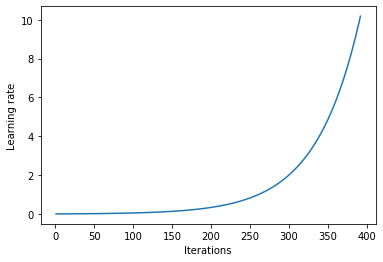

In [135]:
model = model_init()
lr_finder = LR_Finder(start_lr=1e-2, end_lr=10, step_size=np.ceil(trainX.shape[0]/(BATCH_SIZE/LRFNEPOCH)))
model.fit_generator(datagen.flow(trainX, trainY, batch_size = BATCH_SIZE),
                    epochs=LRFNEPOCH,
                    validation_data = (testX, testY), verbose=1,
                    callbacks=[lr_finder])
lr_finder.plot_lr()

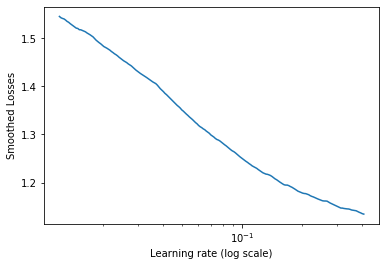

In [136]:
lr_finder.plot_smoothed_loss()

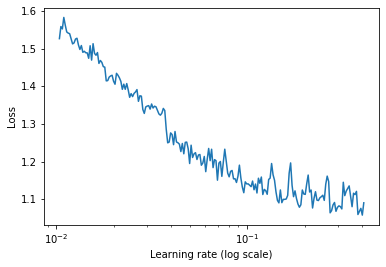

In [137]:
lr_finder.plot()

## Final Run

One Cycle Run was used on a 100 epoch scale. Although, a controlled iterative approach to control LR, momentum and weight decay was attempted the results were not very promising. The network was kind of stopping to approaching the goal. Hence, final run had commented out those parts. However, one can think of achieving a OneCycleLR to get to a stable location and reduce L2 regularization and control other parameters with lesser LR values to get to more deeper minimas. 

The final result was: 87.73 % 

There is possibility of a better accuracy considering the model accuracy has an upward trend suggesting there is a possibility of achieving higher accuracy beyond 100 epochs. However, OneCycleLR beyond 100 epochs did not achieve better accuracy. There was a run with 50 epochs as well which gave a 86.50% accuracy. 30 epoch OneCycleLR was about 84% validation accuracy. 

(?, ?)
Epoch 1/100
97/98 [============================>.] - ETA: 0s - loss: 1.4205 - acc: 0.2034 - rloss: 0.4979
Epoch 00001: val_acc improved from -inf to 0.16570, saving model to save/model.001-0.1657.hdf5
lr: 0.0131, rho: 0.9901, wt_decay: 5.0000e-05
98/98 [==============================] - 119s 1s/step - loss: 1.4192 - acc: 0.2040 - rloss: 0.4977 - val_loss: 1.4633 - val_acc: 0.1657 - val_rloss: 0.4743
Epoch 2/100
97/98 [============================>.] - ETA: 0s - loss: 1.2298 - acc: 0.3231 - rloss: 0.4736
Epoch 00002: val_acc improved from 0.16570 to 0.30790, saving model to save/model.002-0.3079.hdf5
lr: 0.0163, rho: 0.9878, wt_decay: 5.0000e-05
98/98 [==============================] - 16s 168ms/step - loss: 1.2295 - acc: 0.3231 - rloss: 0.4736 - val_loss: 1.3343 - val_acc: 0.3079 - val_rloss: 0.4761
Epoch 3/100
97/98 [============================>.] - ETA: 0s - loss: 1.1453 - acc: 0.3934 - rloss: 0.4797
Epoch 00003: val_acc improved from 0.30790 to 0.41070, saving model to save/

Epoch 22/100
97/98 [============================>.] - ETA: 0s - loss: 0.7882 - acc: 0.6040 - rloss: 0.3838
Epoch 00022: val_acc improved from 0.61800 to 0.61980, saving model to save/model.022-0.6198.hdf5
lr: 0.0796, rho: 0.9403, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 186ms/step - loss: 0.7882 - acc: 0.6043 - rloss: 0.3838 - val_loss: 0.7637 - val_acc: 0.6198 - val_rloss: 0.3792
Epoch 23/100
97/98 [============================>.] - ETA: 0s - loss: 0.7745 - acc: 0.6071 - rloss: 0.3749
Epoch 00023: val_acc did not improve from 0.61980
lr: 0.0828, rho: 0.9379, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 183ms/step - loss: 0.7746 - acc: 0.6071 - rloss: 0.3749 - val_loss: 0.7683 - val_acc: 0.6198 - val_rloss: 0.3707
Epoch 24/100
97/98 [============================>.] - ETA: 0s - loss: 0.7623 - acc: 0.6104 - rloss: 0.3667
Epoch 00024: val_acc improved from 0.61980 to 0.63660, saving model to save/model.024-0.6366.hdf5
lr: 0.0860, rho: 0.9355, 

Epoch 44/100
97/98 [============================>.] - ETA: 0s - loss: 0.5578 - acc: 0.6620 - rloss: 0.2116
Epoch 00044: val_acc did not improve from 0.68510
lr: 0.1493, rho: 0.8880, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 181ms/step - loss: 0.5579 - acc: 0.6618 - rloss: 0.2116 - val_loss: 0.5513 - val_acc: 0.6620 - val_rloss: 0.2083
Epoch 45/100
97/98 [============================>.] - ETA: 0s - loss: 0.5492 - acc: 0.6610 - rloss: 0.2052
Epoch 00045: val_acc did not improve from 0.68510
lr: 0.1525, rho: 0.8856, wt_decay: 5.0000e-05
98/98 [==============================] - 17s 179ms/step - loss: 0.5495 - acc: 0.6609 - rloss: 0.2052 - val_loss: 0.5482 - val_acc: 0.6300 - val_rloss: 0.2019
Epoch 46/100
97/98 [============================>.] - ETA: 0s - loss: 0.5422 - acc: 0.6664 - rloss: 0.1988
Epoch 00046: val_acc did not improve from 0.68510
lr: 0.1556, rho: 0.8833, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 182ms/step - loss: 0.5419 - ac

Epoch 67/100
97/98 [============================>.] - ETA: 0s - loss: 0.4146 - acc: 0.6965 - rloss: 0.0952
Epoch 00067: val_acc did not improve from 0.71150
lr: 0.1945, rho: 0.8542, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 183ms/step - loss: 0.4146 - acc: 0.6964 - rloss: 0.0952 - val_loss: 0.4075 - val_acc: 0.6831 - val_rloss: 0.0935
Epoch 68/100
97/98 [============================>.] - ETA: 0s - loss: 0.4087 - acc: 0.7034 - rloss: 0.0919
Epoch 00068: val_acc did not improve from 0.71150
lr: 0.1937, rho: 0.8547, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 182ms/step - loss: 0.4085 - acc: 0.7035 - rloss: 0.0919 - val_loss: 0.3993 - val_acc: 0.6960 - val_rloss: 0.0902
Epoch 69/100
97/98 [============================>.] - ETA: 0s - loss: 0.4052 - acc: 0.7000 - rloss: 0.0887
Epoch 00069: val_acc did not improve from 0.71150
lr: 0.1929, rho: 0.8553, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 183ms/step - loss: 0.4047 - ac

Epoch 90/100
97/98 [============================>.] - ETA: 0s - loss: 0.3487 - acc: 0.7209 - rloss: 0.0459
Epoch 00090: val_acc did not improve from 0.73800
lr: 0.1763, rho: 0.8678, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 182ms/step - loss: 0.3488 - acc: 0.7207 - rloss: 0.0459 - val_loss: 0.3436 - val_acc: 0.6812 - val_rloss: 0.0453
Epoch 91/100
97/98 [============================>.] - ETA: 0s - loss: 0.3480 - acc: 0.7254 - rloss: 0.0447
Epoch 00091: val_acc did not improve from 0.73800
lr: 0.1755, rho: 0.8684, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 186ms/step - loss: 0.3482 - acc: 0.7251 - rloss: 0.0446 - val_loss: 0.3847 - val_acc: 0.6434 - val_rloss: 0.0440
Epoch 92/100
97/98 [============================>.] - ETA: 0s - loss: 0.3462 - acc: 0.7266 - rloss: 0.0435
Epoch 00092: val_acc did not improve from 0.73800
lr: 0.1747, rho: 0.8690, wt_decay: 5.0000e-05
98/98 [==============================] - 18s 185ms/step - loss: 0.3460 - ac

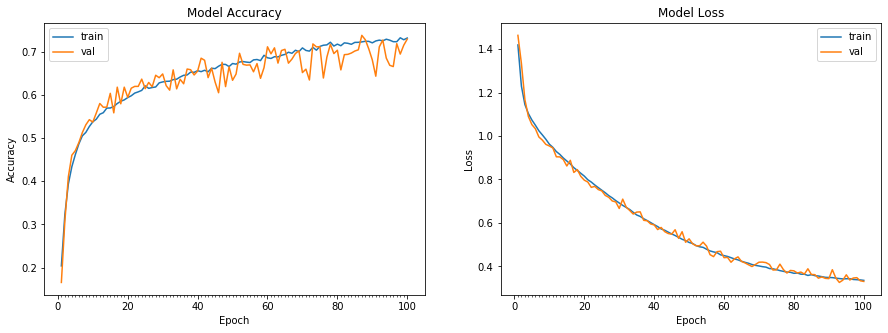

Accuracy on test data is: 72.93


In [139]:
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
from datetime import datetime

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

class CyclicLR(Callback):
    def __init__(self, min_lr, max_lr, upramp=500, downramp=1000):
        super().__init__()
        self.rho = 0.85
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.currstep = 0
        self.upramp = upramp
        self.downramp = downramp
        self.wt_decay = WT_DECAY
        self.min_rho_multiplier = self.rho_multiplier = (1 - self.rho)/(self.wt_decay*max_lr)
        self.max_val_acc = 0.0
        self.max_val_acc_epoch = 0

    def on_train_batch_begin(self, batch, logs=None):
        currstep = self.currstep
        upramp   = self.upramp
        downramp = self.downramp
        min_lr   = self.min_lr
        max_lr   = self.max_lr
        
        dlr = self.max_lr - self.min_lr

        if currstep < upramp :
            dlr /= upramp
            dlr = dlr*currstep
        else:
            dlr /= downramp
            assert currstep <= (upramp + downramp)
            dlr = dlr*(upramp + downramp - currstep)

        if dlr < 0 :
            dlr = 0.0
            
        self.lr = min_lr + dlr
        
        rho = 1 - self.rho_multiplier*self.lr*self.wt_decay
        
        if rho > 0:
            self.rho = rho
        
        K.set_value(self.model.optimizer.lr, self.lr)
        #K.set_value(self.model.optimizer.momentum, self.rho)
        
        self.currstep += 1

    def on_train_batch_end(self, batch, logs=None):
        if self.currstep >= self.upramp + self.downramp:
            self.currstep = 0
    
    def on_epoch_end(self, epoch, logs=None):
        print("lr: {0:.4f}, rho: {1:.4f}, wt_decay: {2:.4e}".format(self.lr, self.rho, self.wt_decay))
        
        if epoch >= 9 and 2*logs.get('val_rloss') > logs.get('val_loss'):
            print("Reducing weight decay by half...")
            #self.wt_decay /= 2
            #K.set_value(self.model.l2_reg, self.wt_decay)
        
        val_acc = logs.get('val_acc')
        
        self.model.stop_training = self.model.stop_training or (val_acc > 0.9)
        
        if self.max_val_acc < val_acc:
            self.max_val_acc = val_acc
            self.max_val_acc_epoch = epoch
            #if (self.rho_multiplier/2) >= self.min_rho_multiplier:
                #print("Restoring momentum multiplier...")
                #self.rho_multiplier = self.min_rho_multiplier
        #elif epoch - self.max_val_acc_epoch > 1:
            #print("Increasing momentum multiplier by double...")
            #self.rho_multiplier *= 2

steps_per_epoch = trainX.shape[0]//BATCH_SIZE+1

clr = CyclicLR(0.01, 0.2, 60*steps_per_epoch, 240*steps_per_epoch)

mcp=ModelCheckpoint("save/model.{epoch:03d}-{val_acc:.4f}.hdf5", 
                    monitor='val_acc', verbose=1, save_best_only=True)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Compile the model
model = model_init()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(trainX, trainY, batch_size = BATCH_SIZE),
                                 epochs=100, shuffle = True,
                                 validation_data = (testX, testY), verbose=1,
                                 callbacks=[mcp, clr, tensorboard_callback])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(testX, testY, model))

In [88]:
tf.__version__

'1.14.0'